## Task
You've received an analytical task from an international online store. Your predecessor failed to complete it: they launched an A/B test and then quit (to start a watermelon farm in Brazil). They left only the technical specifications and the test results.

## Technical description

Test name: interface_eu_test<br>
Groups: А (control), B (new payment funnel)<br>
Launch date: 2020-12-07<br>
Date when they stopped taking up new users: 2020-12-30<br>
End date: 2021-01-01<br>
Audience: 15% of the new users from the EU region<br>
Purpose of the test: testing changes related to the introduction of an improved recommendation system<br>
Expected result: within 14 days of signing up, users will show better conversion into product page views (the product_page event), instances of adding items to the shopping cart (product_cart), and purchases (purchase). At each stage of the funnel product_page → product_cart → purchase, there will be at least a 10% increase.<br>
Expected number of test participants: 6000<br>

## Description of the data

ab_project_marketing_events_us.csv — the calendar of marketing events for 2020<br>
final_ab_new_users_us.csv — all users who signed up in the online store from December 7 to 30, 2020<br>
final_ab_events_us.csv — all events of the new users within the period from December 7, 2020 through January 1, 2021<br>
final_ab_participants_us.csv — table containing test participants<br>

**Structure of `ab_project__marketing_events_us.csv`:**<br>
`name` — the name of the marketing event<br>
`regions` — regions where the ad campaign will be held<br>
`start_dt` — campaign start date<br>
`finish_dt` — campaign end date<br>

**Structure of `final_ab_new_users_us.csv`:**<br>
`user_id`<br>
`first_date` — sign-up date<br>
`region`<br>
`device` — device used to sign up<br>

**Structure of `final_ab_events_us.csv`:**<br>
`user_id`<br>
`event_dt` — event date and time<br>
`event_name` — event type name<br>
`details` — additional data on the event (for instance, the order total in USD for purchase events)<br>

**Structure of `final_ab_participants_us.csv`:**<br>
`user_id`<br>
`ab_test` — test name<br>
`group` — the test group the user belonged to

## Table of contents

- [Explore the data](#explore)
- [Exploratory data analysis](#eda)
- [Study conversion at different stages of the funnel](#funnel)
- [Is the number of events per user distributed equally among the samples](#samples)
- [Are there users who are present in both samples](#check)
- [How is the number of events distributed among days](#days)
- [Are there any peculiarities in the data](#perc)
- [Use a z-test to check the statistical difference between the proportions.](#test)
- [Conclusions regarding the EDA stage and the A/B test results](#conclusion)

<a id='explore'></a>

**Explore the data**

Import libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy.stats as stats
from pandas.core.reshape.concat import concat
import math
from scipy import stats as st

Import files

In [2]:
LOCAL_PATH = 'C:/Users/anna/Desktop/Y-data/Grad Project/AB test/ab_project_marketing_events_us.csv'
PLATFORM_PATH = '/datasets/ab_project_marketing_events_us.csv'
try:
    df_mark_event = pd.read_csv(LOCAL_PATH)
except:
    df_mark_event = pd.read_csv(PLATFORM_PATH)
    
df_mark_event.head(2)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16


In [3]:
LOCAL_PATH = 'C:/Users/anna/Desktop/Y-data/Grad Project/AB test/final_ab_new_users_us.csv'
PLATFORM_PATH = '/datasets/final_ab_new_users_us.csv'
try:
    df_new_users = pd.read_csv(LOCAL_PATH)
except:
    df_new_users = pd.read_csv(PLATFORM_PATH)
    
df_new_users.head(2)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android


In [4]:
LOCAL_PATH = 'C:/Users/anna/Desktop/Y-data/Grad Project/AB test/final_ab_events_us.csv'
PLATFORM_PATH = '/datasets/final_ab_events_us.csv'
try:
    df_ab_events = pd.read_csv(LOCAL_PATH)
except:
    df_ab_events = pd.read_csv(PLATFORM_PATH)
    
df_ab_events.head(2)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99


In [5]:
LOCAL_PATH = 'C:/Users/anna/Desktop/Y-data/Grad Project/AB test/final_ab_participants_us.csv'
PLATFORM_PATH = '/datasets/final_ab_participants_us.csv'
try:
    df_ab_part = pd.read_csv(LOCAL_PATH)
except:
    df_ab_part = pd.read_csv(PLATFORM_PATH)
    
df_ab_part.head(2)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test


Find the number of rows in the datasets

In [6]:
print('The number of rows in the marketing events dataset is {}'.format(df_mark_event.shape[0]))
print('The number of rows in the new users dataset is {}'.format(df_new_users.shape[0]))
print('The number of rows in the ab events dataset is {}'.format(df_ab_events.shape[0]))
print('The number of rows in the ab participants dataset is {}'.format(df_ab_part.shape[0]))

The number of rows in the marketing events dataset is 14
The number of rows in the new users dataset is 61733
The number of rows in the ab events dataset is 440317
The number of rows in the ab participants dataset is 18268


The number of unique users in the dataset

In [7]:
print('The number of unique users is {}'.format(df_new_users.user_id.nunique()))

The number of unique users is 61733


In [8]:
print('The number of unique users is {}'.format(df_ab_events.user_id.nunique()))

The number of unique users is 58703


We see that 3000 users are missing in the events table. Users that exist in participant table didn't get into events table, most likely because they were assigned to the test, but didn't do any actions.

Checking is there any data types that need to be converted

In [9]:
df_mark_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


I'll convert dates to datetime format

In [10]:
df_mark_event['start_dt'] = pd.to_datetime(df_mark_event['start_dt'], format= '%Y/%m/%d')
df_mark_event['finish_dt'] = pd.to_datetime(df_mark_event['finish_dt'], format= '%Y/%m/%d')

In [11]:
df_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [12]:
#converting to datetime format
df_new_users['first_date'] = pd.to_datetime(df_new_users['first_date'], format= '%Y/%m/%d')

In [13]:
df_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [14]:
#converting to datetime format
df_ab_events['event_dt'] = df_ab_events['event_dt'].astype('datetime64[ns]')

In [15]:
df_ab_part.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Do any of the rows have missing values?

In [16]:
print('There are {} missing values in marketing events data.'.format(df_mark_event.isnull().any().sum()))
print('There are {} missing values in new users data.'.format(df_new_users.isnull().any().sum()))
print('There are {} missing values in ab events data.'.format(df_ab_events.isnull().any().sum()))
print('There are {} missing values in ab participants data.'.format(df_ab_part.isnull().any().sum()))

There are 0 missing values in marketing events data.
There are 0 missing values in new users data.
There are 1 missing values in ab events data.
There are 0 missing values in ab participants data.


Theres only 1 missing value in ab events data, we can neglect it.

Cheking the dublicates

In [17]:
print('There are {} dublicated values in marketing events data.'.format(df_mark_event.duplicated().sum()))
print('There are {} dublicated values in new users data.'.format(df_new_users.duplicated().sum()))
print('There are {} dublicated values in ab events data.'.format(df_ab_events.duplicated().sum()))
print('There are {} dublicated values in ab participants data.'.format(df_ab_part.duplicated().sum()))

There are 0 dublicated values in marketing events data.
There are 0 dublicated values in new users data.
There are 0 dublicated values in ab events data.
There are 0 dublicated values in ab participants data.


What period of time does the data for all events of the new users cover?

In [18]:
print(df_ab_events.event_dt.min())
print(df_ab_events.event_dt.max())

2020-12-07 00:00:33
2020-12-30 23:36:33


<a id='eda'></a>

**Exploratory data analysis**

As we are going to work with `interface_eu_test` I'll create new dataframe, which contains only this test results.

In [19]:
df_ab_part.head(2)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test


In [20]:
df_ab_part.ab_test.value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

In [21]:
df_eu_test = df_ab_part.query('ab_test == "interface_eu_test"')
df_eu_test.shape[0]

11567

In [22]:
#cheking the number of users in each group
df_eu_test.group.value_counts()

A    5831
B    5736
Name: group, dtype: int64

See what events are in the logs and their frequency of occurrence. Sort them by frequency.

In [23]:
df_ab_events.event_name.value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

<a id='funnel'></a>

**Study conversion at different stages of the funnel**

In [24]:
df_eu_test.head()

,user_id,group,ab_test
6701,D4E530F6595A05A3,A,interface_eu_test
6702,773ECB64E45DEBAB,A,interface_eu_test
6703,6BCB0F33D3BAB8C2,A,interface_eu_test
6704,AABA4219186465C9,A,interface_eu_test
6705,2BA8FA8754D1FE50,B,interface_eu_test


In [25]:
df_eu_test.reset_index(drop=True)
df_eu_test.head()

,user_id,group,ab_test
6701,D4E530F6595A05A3,A,interface_eu_test
6702,773ECB64E45DEBAB,A,interface_eu_test
6703,6BCB0F33D3BAB8C2,A,interface_eu_test
6704,AABA4219186465C9,A,interface_eu_test
6705,2BA8FA8754D1FE50,B,interface_eu_test


In [26]:
df_ab_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [27]:
df_ab_events.shape[0]

440317

In [28]:
#creating dataset with users, which are presented only in df_eu_test group
events = df_ab_events[df_ab_events['user_id'].isin(df_eu_test.user_id)]
events

,user_id,event_dt,event_name,details
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99
11,354D653172FF2A2D,2020-12-07 15:45:11,purchase,4.99
12,7FCD34F47C13A9AC,2020-12-07 22:06:13,purchase,9.99
13,0313C457F07C339E,2020-12-07 13:10:48,purchase,9.99
...,...,...,...,...
440286,5C31C0607EFC3C98,2020-12-30 01:56:08,login,NaN
440291,4584E51B99DE51AE,2020-12-30 07:39:32,login,NaN
440292,9DF4F595A906A0BA,2020-12-30 18:28:55,login,NaN
440311,6181F3835EBE66BF,2020-12-30 12:00:00,login,NaN


In [29]:
#merging 2 tables to get full information on a/b testing groups in one dataset
df_new = events.merge(df_eu_test, on='user_id', how='left')
df_new.head()

,user_id,event_dt,event_name,details,group,ab_test
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B,interface_eu_test
1,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99,A,interface_eu_test
2,354D653172FF2A2D,2020-12-07 15:45:11,purchase,4.99,A,interface_eu_test
3,7FCD34F47C13A9AC,2020-12-07 22:06:13,purchase,9.99,B,interface_eu_test
4,0313C457F07C339E,2020-12-07 13:10:48,purchase,9.99,A,interface_eu_test


Let's calculate the number of users at each stage of the funnel

In [30]:
df_new.event_name.value_counts()

login           35145
product_page    23095
purchase        12085
product_cart    11602
Name: event_name, dtype: int64

Tech description says that the funnel = product_page → product_cart → purchase. We also know that users don't have to go to each stage in a specific sequence, as there is a button that redirects a user straight to the purchase page. This is a reason why we got more users on purchase than on the product_cart page. 

Next, I'll calculate the conversion on each stage fot both groups.

In [31]:
#creating 2 datsets for both groups
group_A = df_new[df_new['group'] == "A"]
group_B = df_new[df_new['group'] == "B"]

In [32]:
#conversion for group A
conversion_A=group_A.groupby(['event_name'])['user_id'].nunique().reset_index().sort_values(by='user_id',ascending=False)
conversion_A['conversion']=conversion_A['user_id'] / group_A.user_id.nunique()
conversion_A.style.format({'conversion': "{:.2%}"}).hide_index()

event_name,user_id,conversion
login,5466,99.98%
product_page,3639,66.56%
purchase,1931,35.32%
product_cart,1756,32.12%


In [33]:
#conversion for group B
conversion_B = group_B.groupby(['event_name'])['user_id'].nunique().reset_index().sort_values(by='user_id',ascending=False)
conversion_B['conversion']=conversion_B['user_id'] / group_B.user_id.nunique()
conversion_B.style.format({'conversion': "{:.2%}"}).hide_index()

event_name,user_id,conversion
login,5383,100.00%
product_page,3527,65.52%
product_cart,1812,33.66%
purchase,1782,33.10%


We see that conversion for all events are more or less the same. My next step will be to use a z-test to check the statistical difference between the proportions.

<a id='samples'></a>

**Is the number of events per user distributed equally among the samples?**

In [34]:
df_new = df_new.astype({'event_name': 'object', 'group': 'object'})
pivot = df_new.pivot_table(index='event_name', values='user_id', columns='group', aggfunc=lambda x: x.nunique()).reset_index()
pivot

group,event_name,A,B
0,login,5466,5383
1,product_cart,1756,1812
2,product_page,3639,3527
3,purchase,1931,1782


We see that there's no significant differentce between control group and test group.

**Are there users who are present in both samples?**

In [35]:
#checking if we have users that got into 2 groups
user_group = df_new.groupby('user_id').agg({'group': 'nunique'}).sort_values(by='user_id', ascending=False).reset_index()
user_group.head(5)

,user_id,group
0,FFF58BC33966EB51,1
1,FFF28D02B1EACBE1,1
2,FFEFC0E55C1CCD4F,1
3,FFE7FC140521F5F6,1
4,FFE600EEC4BA7685,1


In [36]:
user_group.group.value_counts()

1    10850
Name: group, dtype: int64

There're no users that got into 2 groups

<a id='days'></a>

**How is the number of events distributed among days?**

In [37]:
df_new['day'] = df_new['event_dt'].dt.dayofweek
df_new.head(2)

,user_id,event_dt,event_name,details,group,ab_test,day
0,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,B,interface_eu_test,0
1,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99,A,interface_eu_test,0


In [38]:
day = df_new.pivot_table(index=['day'], values='event_dt', aggfunc='count').sort_values(by='day').reset_index()
day['share'] = day['event_dt'] / df_new.event_dt.count()
day[['day', 'event_dt', 'share']].style.format({'share': "{:.2%}"}).hide_index()

day,event_dt,share
0,15037,18.35%
1,13769,16.81%
2,11272,13.76%
3,10356,12.64%
4,9820,11.99%
5,10475,12.79%
6,11198,13.67%


We see that biggest amount of events falls for Monday(0) = 18.35% and less amount for Friday(4) = 11.99%
I will also plot a graph to see the distribution of events per days.

In [39]:
#get only date from datetime
df_new['event_date'] = df_new['event_dt'].dt.date

In [40]:
dates = df_new.groupby('event_date')['user_id'].count().reset_index()
dates.head()

,event_date,user_id
0,2020-12-07,2068
1,2020-12-08,2311
2,2020-12-09,2333
3,2020-12-10,2551
4,2020-12-11,2603


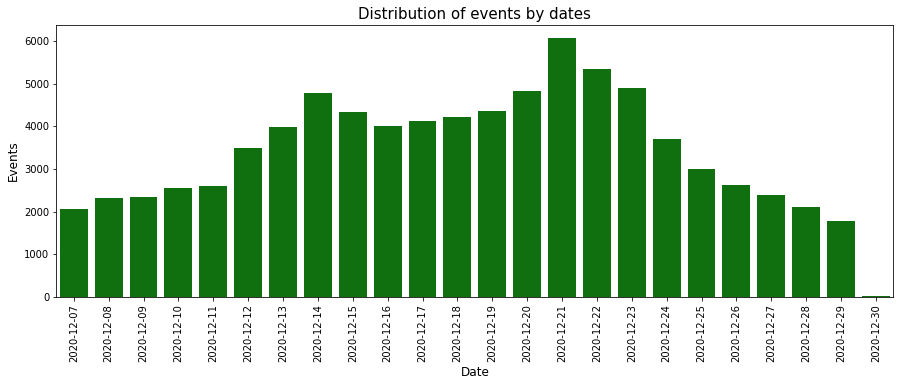

In [41]:
# plotting a histogram by date 
# set figure size
plt.figure(figsize=(15,5))

# plotting bar graph
ax = sns.barplot(x='event_date', y='user_id', data=dates, palette=['green'])
plt.xticks(rotation=90)

# naming graph
ax.set_title('Distribution of events by dates', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Events', fontsize=12);

We see that events presented at each day and we have a pick during 2020-12-22 - 2020-12-23. It could be because users were looking for Christmas gifts and demand on purchases increased.

<a id='perc'></a>

**Are there any peculiarities in the data that you have to take into account before starting the A/B test?**

I didn't find any peculiarities in the data, as:
- we don't have users that were  assigned to both tests
- users were split equally

But I'd say that running the A/B test during the National holidays could lead to results different from those, that we would get during regular days, as users could behave differently during holidays.

<a id='test'></a>

**Use a z-test to check the statistical difference between the proportions.**

1. Let's check whether control group and test group are significantly different.
2. Let's formulate hypothesis. Null hypothesis Ho: proportions of the groups A and B are equal. Alternative hypothesis H1: proportions of the groups A and B are different.
3. Alpha = 0.05.

In [42]:
#how many users is each group
users_number = df_new.groupby('group').user_id.nunique().reset_index()
users_number['share'] = users_number['user_id'] / df_new.user_id.nunique()
users_number[['group', 'user_id', 'share']].style.format({'share': "{:.2%}"}).hide_index()

group,user_id,share
A,5467,50.39%
B,5383,49.61%


In [43]:
#number of successes in each group
successes1=users_number['user_id'].iloc[0]
successes2=users_number['user_id'].iloc[1]
    
# calculating trials 
trials=df_new.user_id.nunique()
    
alpha = .05    
    
#proportion for success in the first group
p1 = successes1/trials

#proportion for success in the second group
p2 = successes2/trials

# proportion in a combined dataset
p_combined = (successes1 + successes2) / (trials + trials)
 
difference = p1 - p2    
z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials + 1/trials)) 
distr = st.norm(0, 1) 
p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if (p_value < alpha):
    print("Reject H0: there is no significant diffrence between the proportions")
else:
    print("Fail to Reject H0: there is no reason to consider the proportions are different")

p-value:  0.25409541110640776
Fail to Reject H0: there is no reason to consider the proportions are different


Conclusion: The z-test shows that there is no reason to consider the proportions are different.

Next step I'll repeat the procedure for all the events for both groups.

I'll test the share of users in the groups for each event and use z-test of proportions for this.<br>
Formulating hypothesis:<br>
Null hypothesis H₀: The conversion (proportion) in group A is equal to conversion in group B.<br>
Alternative hypothesis H₁: The conversion in group A is statistically different from group B.<br>
Alpha = 0.05.<br>

In [44]:
#creating function
def check_hypothesis(group1,group2, event, alpha=0.05):
    #let's start with successes, using 
    successes1=pivot[pivot.event_name==event][group1].iloc[0]
    successes2=pivot[pivot.event_name==event][group2].iloc[0]
    
    #for trials go back to original df or used a pre-aggregated data
    trials1=df_new[df_new.group==group1]['user_id'].nunique()
    trials2=df_new[df_new.group==group2]['user_id'].nunique()
    
    #proportion for success in the first group
    p1 = successes1/trials1
    
   #proportion for success in the second group
    p2 = successes2/trials2

    # proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)

    difference = p1 - p2      
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2)) 
    distr = st.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)

    if (p_value < alpha):
        print("Reject H0 for",event, 'and groups',group1,group2)
    else:
        print("Fail to Reject H0 for", event,'and groups',group1,group2)

Let's conduct test of proportions to check whether the difference between the groups is statistically significant for purchase event.

In [45]:
check_hypothesis("A","B", 'purchase', alpha=0.05)

p-value:  0.014959088807690257
Reject H0 for purchase and groups A B


Concludion: there's no statistically significant diffrence between proportions of purchase event in groups A and B.

Next, I'll repeat the procedure for all other events.

In [46]:
for i in pivot.event_name.unique():
    check_hypothesis("A","B", i, alpha=0.05)

p-value:  0.32103485047255065
Fail to Reject H0 for login and groups A B
p-value:  0.08746918913258162
Fail to Reject H0 for product_cart and groups A B
p-value:  0.2518419682737163
Fail to Reject H0 for product_page and groups A B
p-value:  0.014959088807690257
Reject H0 for purchase and groups A B


Concludion: There is no statistical difference in conversion between samples A and B.

<a id='conclusion'></a>

**Conclusions regarding the EDA stage and the A/B test results**

- The `goal` of the analysis was to investigate user behavior for the international online store.
- After studying the results of the experiment I didn't find any significant difference in convertion between A and B groups.
- The test was running during the holidays, which could lead to results different from regular days. We saw spike on Christmas eve, which shows that holidays affected the demand for purchases.